
*La empresa necesita poder estimar la demanda de velas a partir de la información proporcionada.*

| Campo | Descripcion |
|--------------|--------------|
| CODMES   | Indicadoe del periodo Año-Mes    |
| CODPROD    | Código de producto   |
| DESC_PROD    | Nombre del producto|
| UBICA | Ubicación del producto dentro de la tienda|
| PRE_REG | Precio Regular|
| PRE_OFE | Precio con oferta |
| PCT_DSCTO | Descuento aplicado (%) |
| UN_ESTIMADAS |Unidades estimadas |
| **UN_DEMANDADAS** |Unidades demandadas (target) |
| TRAF_TDA_CLI | Trafico de la tienda por cliente|
| TIPO_CAMB | Tipo de cambio|
| MAPE | MAPE |


---

## **Configuración Inicial**

**Conexion Drive**

In [33]:
# Si necesitas ejecutar el notebook con un archivo desde tu drive personal
# from google.colab import drive
# drive.mount('/gdrive')

#Repositorios
# path = '/gdrive/MyDrive/BQ - Data Science/BQ - Repositorios/Repositorio_Portafolio/'
# filename = "demanda_velas.csv"
# fullpath = os.path.join(path, filename)

**Librerias**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Para los graficos tengan las mismas dimensiones
%matplotlib inline
plt.style.use('ggplot')

pd.options.display.max_columns = None
sns.set_style('whitegrid')
color = sns.color_palette()

**Rutas**

In [36]:
fullpath = "https://raw.githubusercontent.com/bryanOsmar07/personal-projects-portafolio/main/Data/demanda_velas.csv"

# **I. Carga de datos**

In [37]:
df = pd.read_csv(fullpath)

In [38]:
print(df.shape)
df.head(3)

(646, 12)


,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,UN_ESTIMADAS,UN_DEMANDADAS,TRAF_TDA_CLI,TIPO_CAMB,MAPE
0,201802,8019010,VELA PERFUMADA 3 MEDIANA,Nivel Alto Anaquel,74,44.9,0.39,1105,751,140209,2.554,0.471
1,201803,8019010,VELA PERFUMADA 3 MEDIANA,Nivel Alto Anaquel,74,49.9,0.33,751,736,137783,2.572,0.020
2,201805,8019010,VELA PERFUMADA 3 MEDIANA,Nivel Alto Anaquel,76,46.9,0.38,736,1130,132480,2.594,0.349


## **Data Wrangling**

In [39]:
df.columns

Index(['CODMES', 'CODPROD', 'DESC_PROD', 'UBICA', 'PRE_REG', 'PRE_OFE',
       'PCT_DSCTO', 'UN_ESTIMADAS', 'UN_DEMANDADAS', 'TRAF_TDA_CLI',
       'TIPO_CAMB', 'MAPE'],
      dtype='object')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CODMES         646 non-null    int64  
 1   CODPROD        646 non-null    int64  
 2   DESC_PROD      646 non-null    object 
 3   UBICA          646 non-null    object 
 4   PRE_REG        646 non-null    int64  
 5   PRE_OFE        646 non-null    float64
 6   PCT_DSCTO      646 non-null    float64
 7   UN_ESTIMADAS   646 non-null    int64  
 8   UN_DEMANDADAS  646 non-null    int64  
 9   TRAF_TDA_CLI   646 non-null    int64  
 10  TIPO_CAMB      646 non-null    float64
 11  MAPE           646 non-null    float64
dtypes: float64(4), int64(6), object(2)
memory usage: 60.7+ KB


Revisamos duplicados

In [41]:
df.duplicated().any()

False

* Eliminamos las características innecesarias

In [42]:
df_prev = df.copy()

In [43]:
df = df.drop(['CODMES', 'CODPROD','UN_ESTIMADAS','MAPE'],axis=1)

In [44]:
columnsString = ['UBICA','DESC_PROD']
columnsNumeric = [x for x in df.columns if x not in columnsString]

In [45]:
# Validando registros únicos
print(df.shape)
print(df[columnsString].nunique())

(646, 8)
UBICA         4
DESC_PROD    25
dtype: int64


# **II. Analisis Exploratorio**

In [46]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DESC_PROD,646,25,VELA PERFUMADA 1 GRANDE,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UBICA,646,4,Nivel Alto Anaquel,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRE_REG,646.0,NaN,NaN,NaN,99.55418,45.294311,50.0,59.0,75.0,146.0,178.0
PRE_OFE,646.0,NaN,NaN,NaN,63.719814,38.362254,24.9,35.9,44.9,86.65,178.0
PCT_DSCTO,646.0,NaN,NaN,NaN,0.38226,0.133331,0.0,0.31,0.39,0.5,0.66
UN_DEMANDADAS,646.0,NaN,NaN,NaN,3371.750774,6921.317825,0.0,175.5,886.0,2788.0,58156.0
TRAF_TDA_CLI,646.0,NaN,NaN,NaN,134913.433437,10201.19718,116299.0,127615.0,137783.0,144188.0,149276.0
TIPO_CAMB,646.0,NaN,NaN,NaN,2.75981,0.099968,2.551,2.716,2.798,2.824,2.884


## Revision Objetivo

UN_DEMANDADAS ==> Cantidad de unidades demandadas

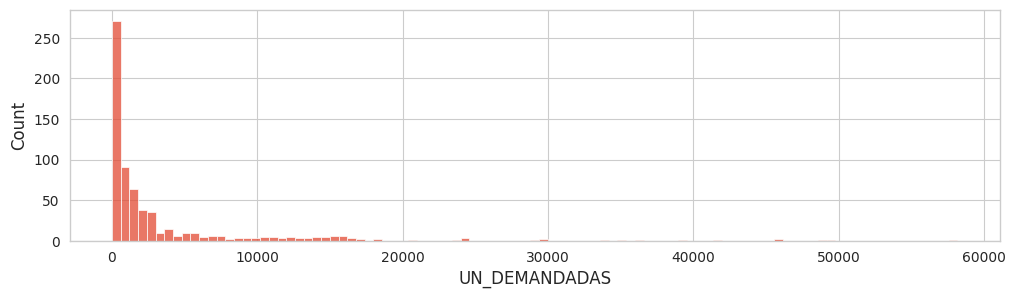

In [47]:
plt.figure(figsize=(12,3))
sns.histplot(x='UN_DEMANDADAS', data=df);

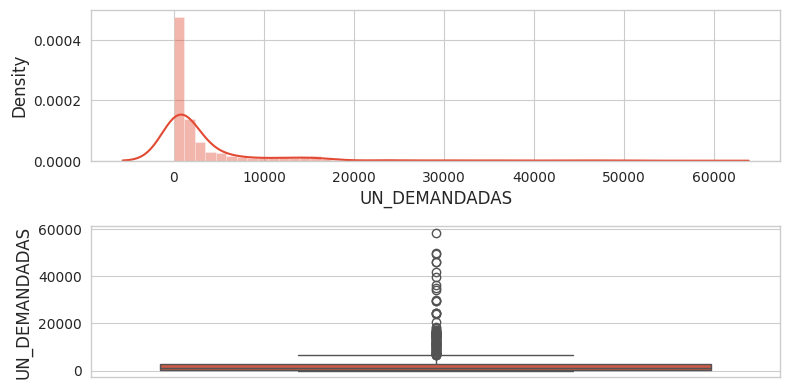

In [48]:
fig = plt.figure(figsize=(8,4))
fig.add_subplot(2,1,1)
sns.distplot(df['UN_DEMANDADAS'])
fig.add_subplot(2,1,2)
sns.boxplot(df['UN_DEMANDADAS'])
plt.tight_layout()

## Analisis Univariado

### Categoricas

UBICA
Cabecera de Gondola    113
Centro de Anaquel      107
Nivel Alto Anaquel     394
Nivel Bajo Anaquel      32
dtype: int64


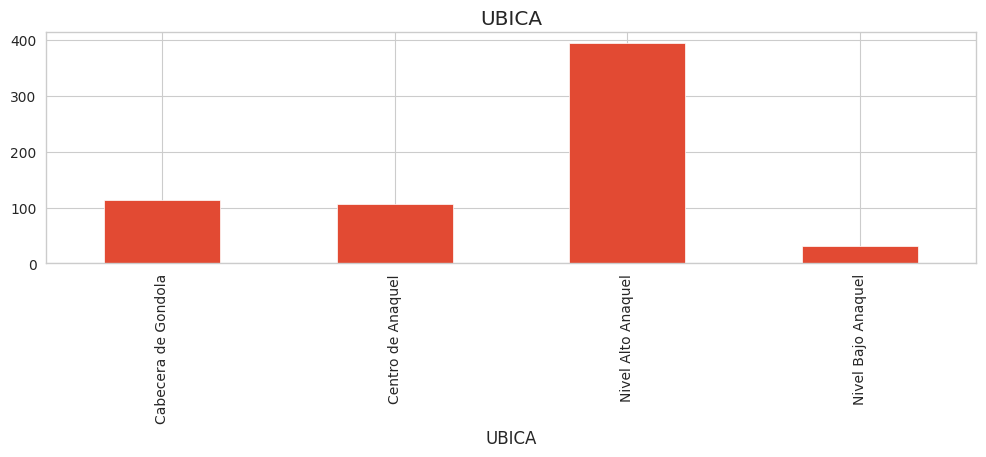

DESC_PROD
VELA PERFUMADA 1 CHICA       24
VELA PERFUMADA 1 GRANDE      36
VELA PERFUMADA 1 MEDIANA     29
VELA PERFUMADA 10 GRANDE     24
VELA PERFUMADA 10 MEDIANA    24
VELA PERFUMADA 11 GRANDE     24
VELA PERFUMADA 11 MEDIANA    24
VELA PERFUMADA 2 CHICA       24
VELA PERFUMADA 2 GRANDE      29
VELA PERFUMADA 2 MEDIANA     29
VELA PERFUMADA 3 CHICA       24
VELA PERFUMADA 3 GRANDE      28
VELA PERFUMADA 3 MEDIANA     28
VELA PERFUMADA 4 GRANDE      26
VELA PERFUMADA 4 MEDIANA     26
VELA PERFUMADA 5 GRANDE      25
VELA PERFUMADA 5 MEDIANA     25
VELA PERFUMADA 6 GRANDE      25
VELA PERFUMADA 6 MEDIANA     25
VELA PERFUMADA 7 GRANDE      25
VELA PERFUMADA 7 MEDIANA     25
VELA PERFUMADA 8 GRANDE      25
VELA PERFUMADA 8 MEDIANA     24
VELA PERFUMADA 9 GRANDE      24
VELA PERFUMADA 9 MEDIANA     24
dtype: int64


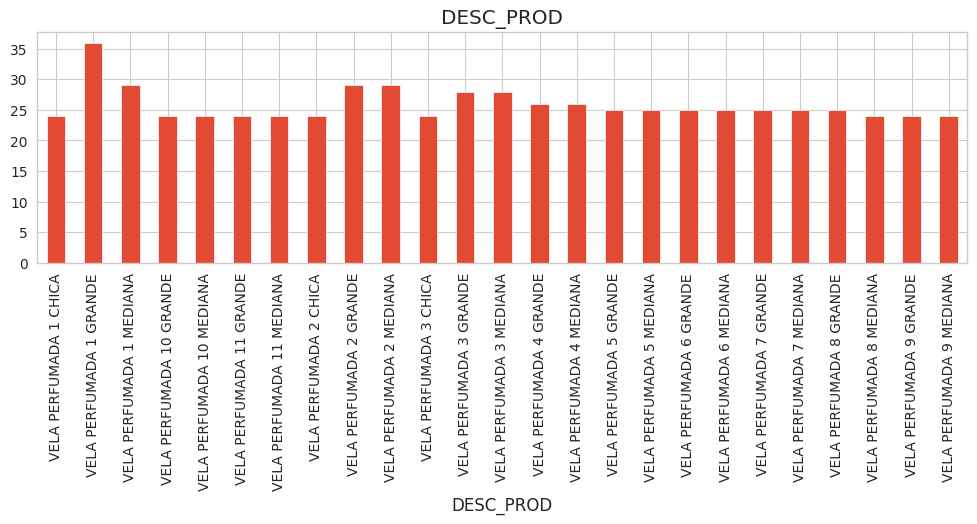

In [49]:
for x in columnsString:
  plt.figure(figsize=(12,3))
  print(df.groupby(x).size())
  plt.title(x)
  df.fillna("--NULL").groupby(x)[x].count().plot(kind = "bar")
  plt.show()

### Numericas

In [50]:
df[columnsNumeric].describe().T

,count,mean,std,min,25%,50%,75%,max
PRE_REG,646.0,99.554180,45.294311,50.000,59.000,75.000,146.000,178.000
PRE_OFE,646.0,63.719814,38.362254,24.900,35.900,44.900,86.650,178.000
PCT_DSCTO,646.0,0.382260,0.133331,0.000,0.310,0.390,0.500,0.660
UN_DEMANDADAS,646.0,3371.750774,6921.317825,0.000,175.500,886.000,2788.000,58156.000
TRAF_TDA_CLI,646.0,134913.433437,10201.197180,116299.000,127615.000,137783.000,144188.000,149276.000
TIPO_CAMB,646.0,2.759810,0.099968,2.551,2.716,2.798,2.824,2.884


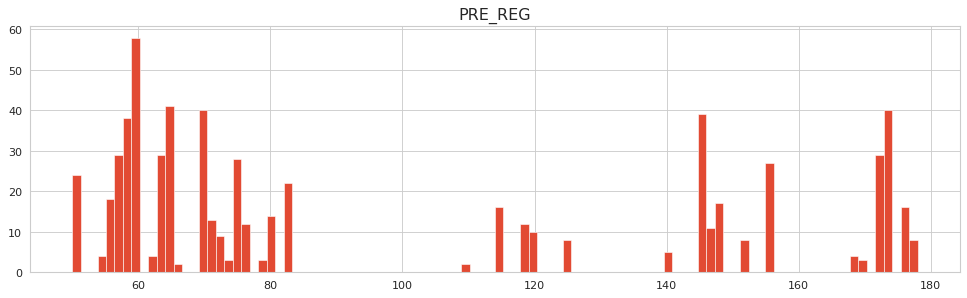

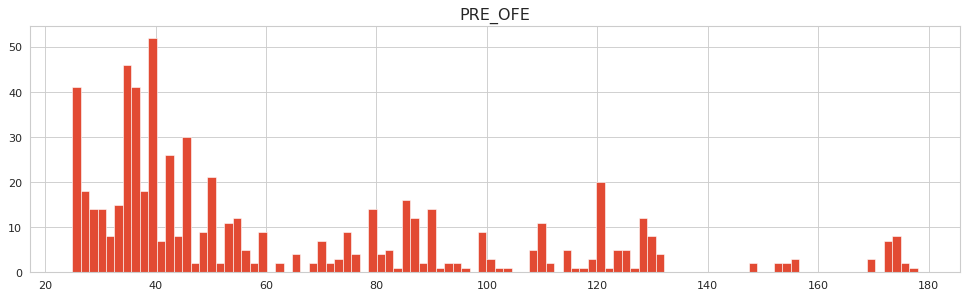

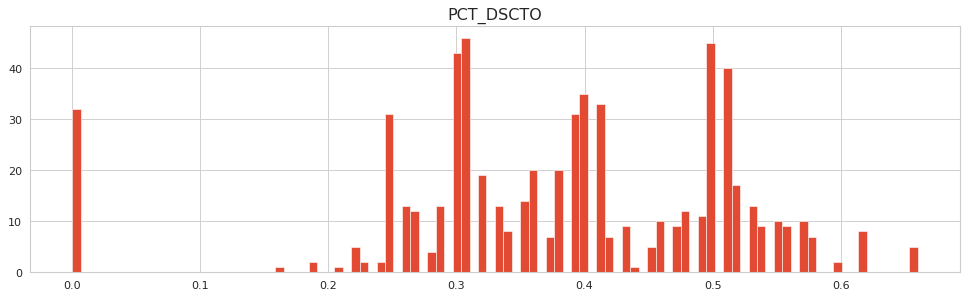

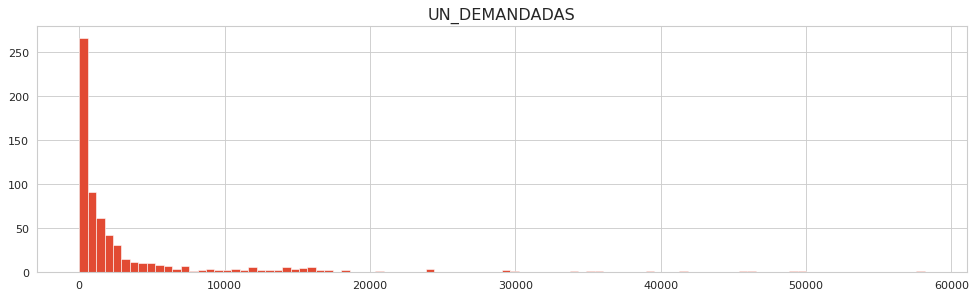

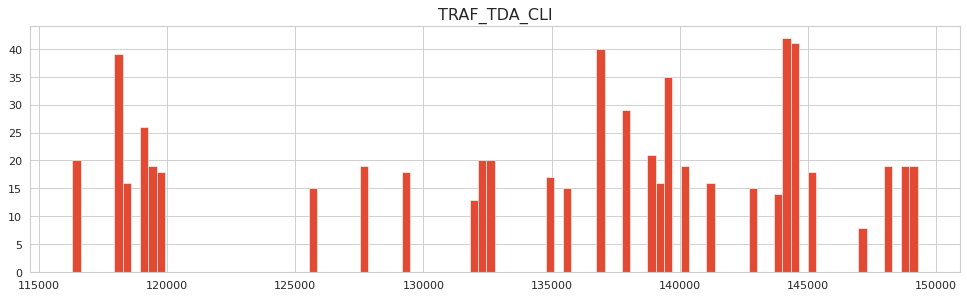

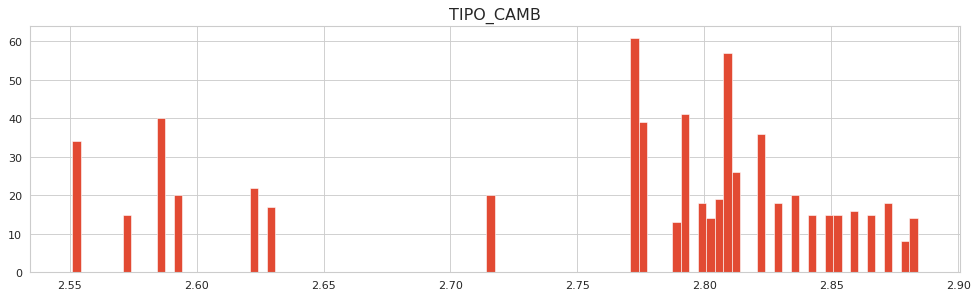

In [52]:
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  plt.hist(df[x],bins=100)
  plt.show()

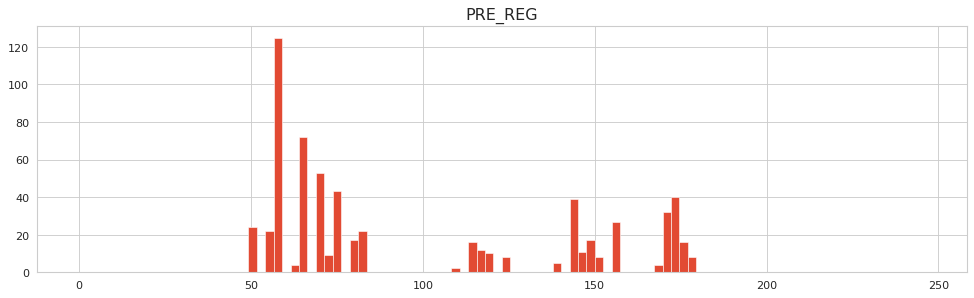

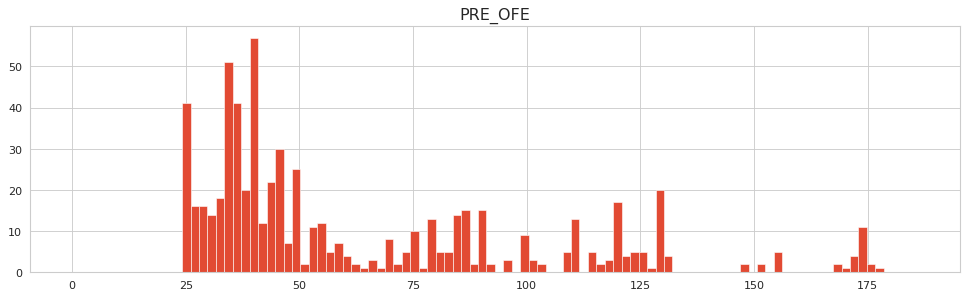

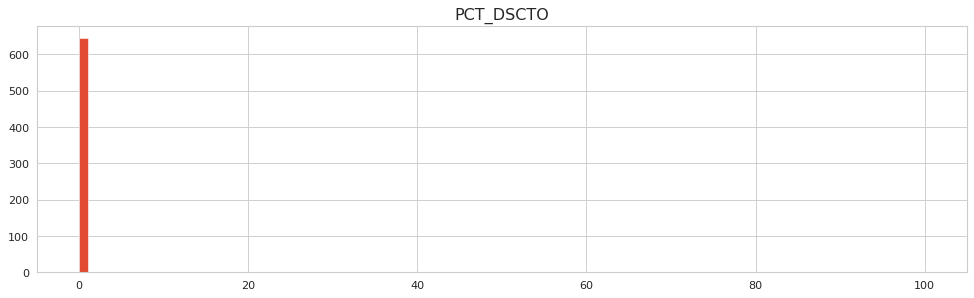

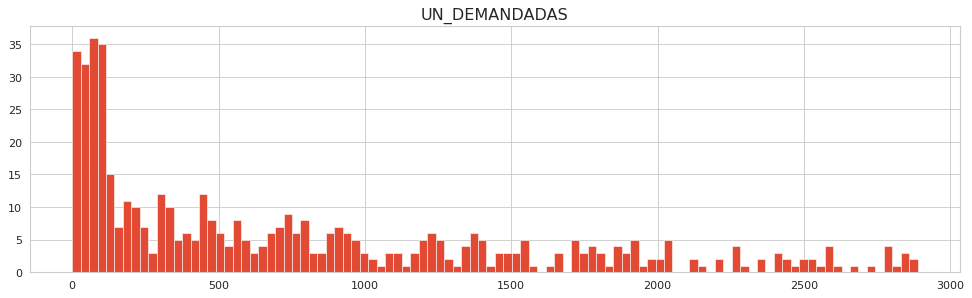

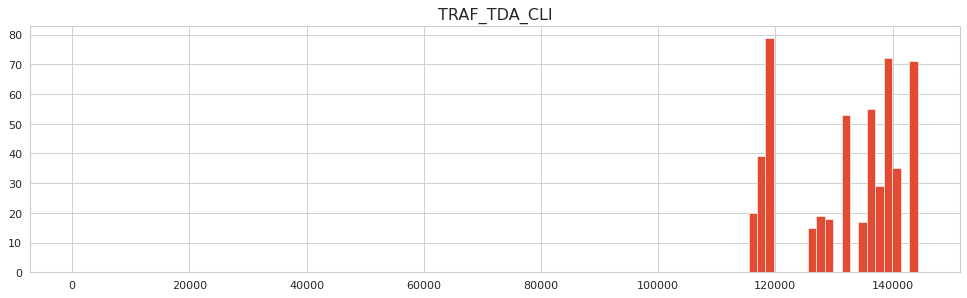

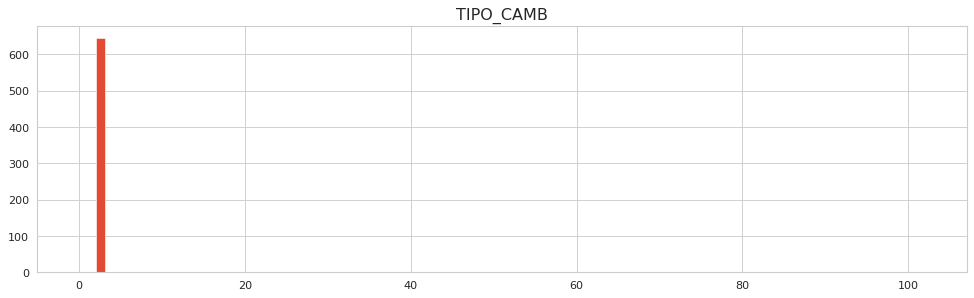

In [53]:
# No consideramos las colas (outliers) para ver mejor la distribucion
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  Q03= int(df[x].quantile(0.75))+100
  plt.title(df[x].name)
  plt.hist(df[x],bins=100,range=(0,Q03))
  plt.show()

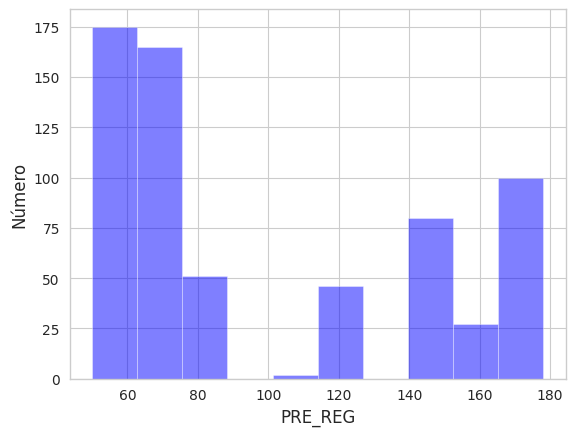

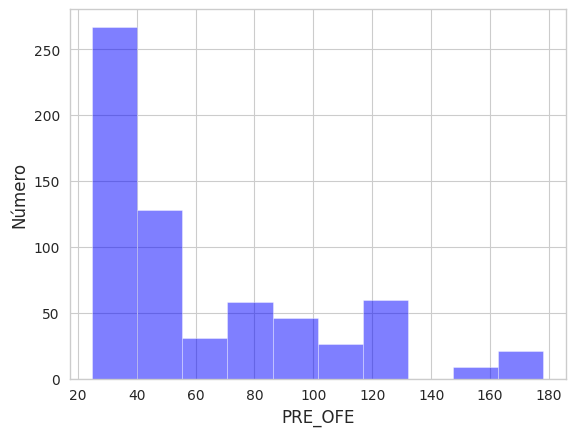

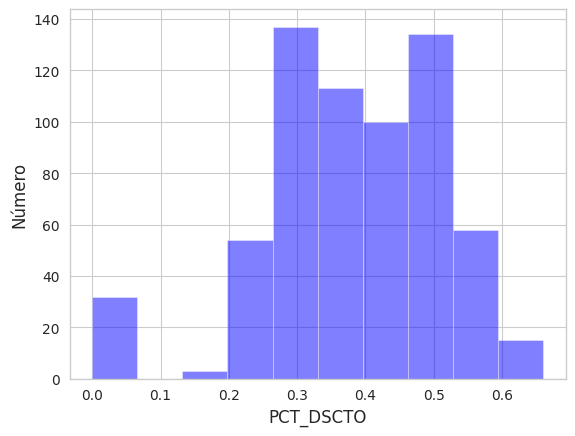

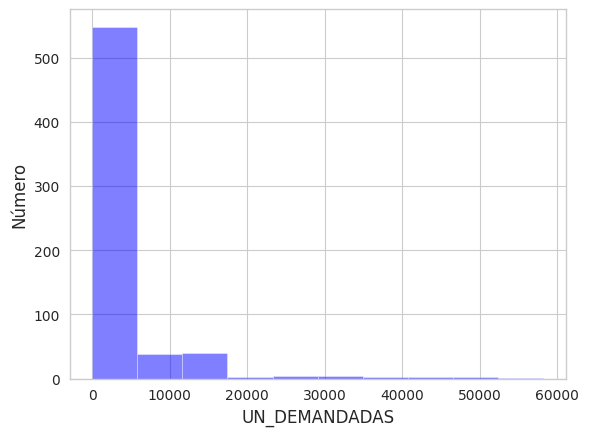

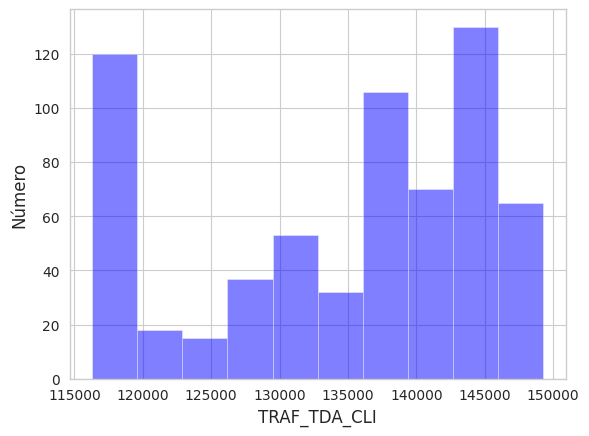

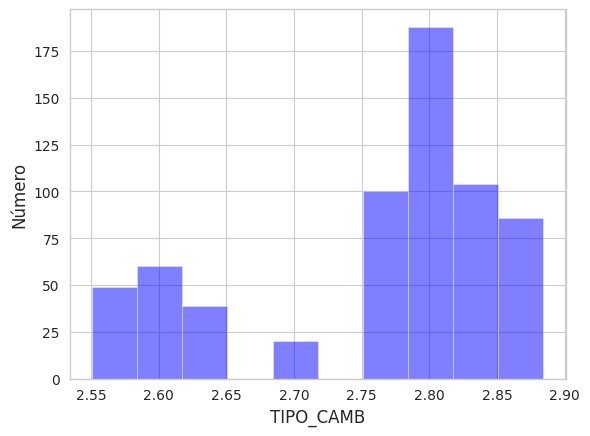

In [54]:
num_bins = 10
data_0 = df

for i in columnsNumeric:
    n, bins, patches = plt.hist(data_0[i], num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel(i)
    plt.ylabel('Número')
    plt.show()

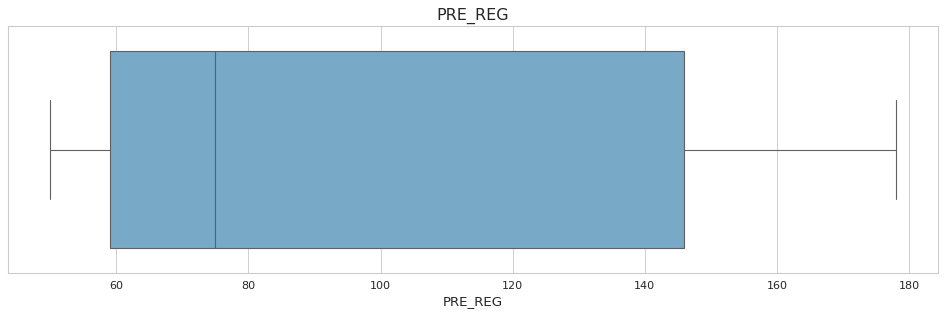

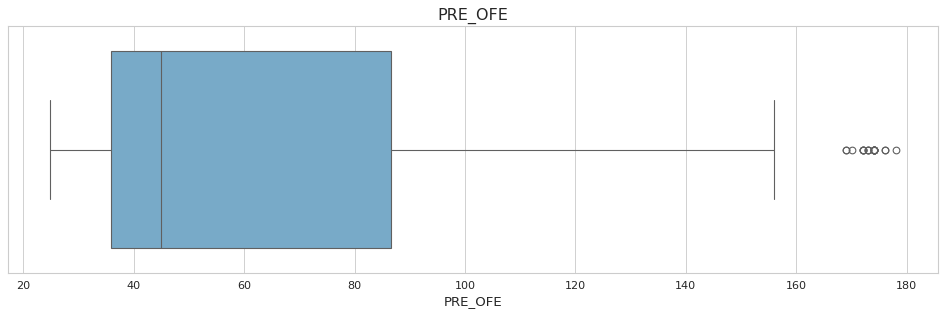

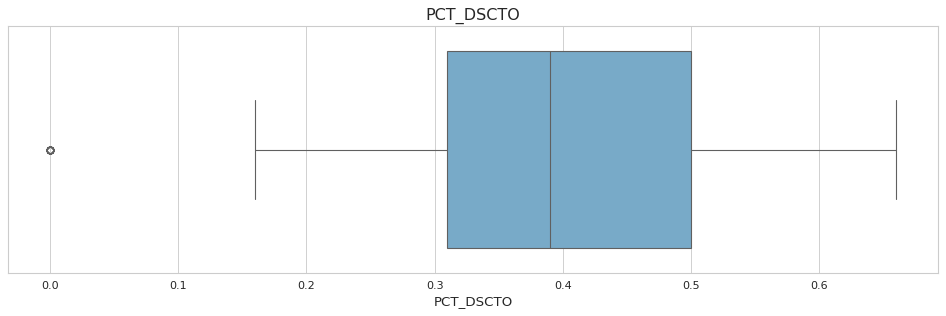

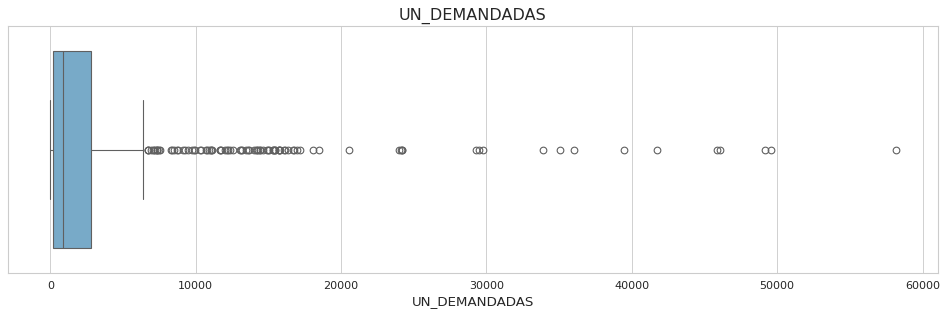

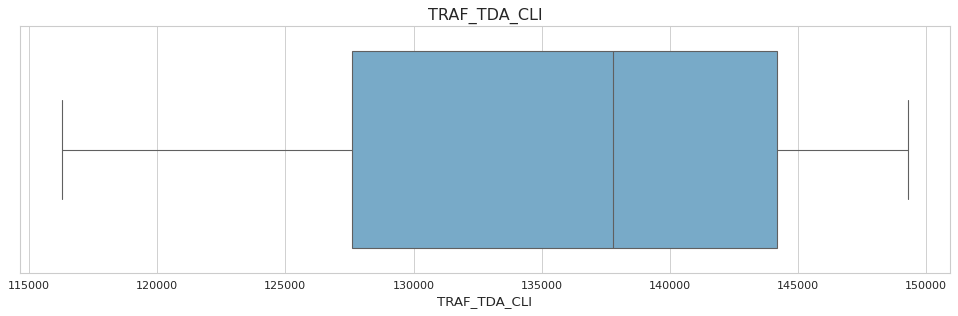

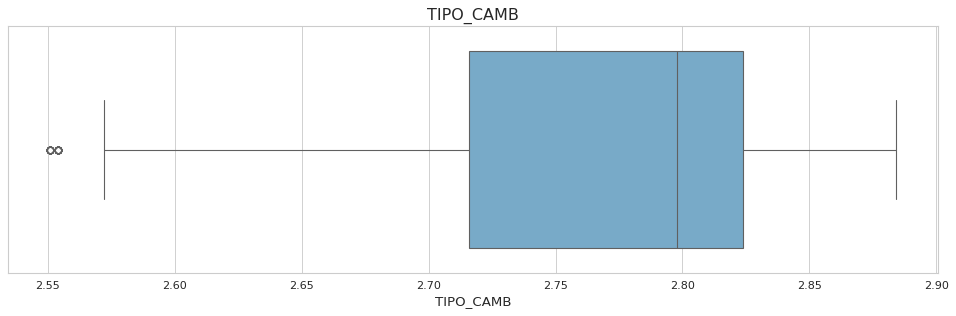

In [55]:
# Grafico de Cajas para revision de atipicos
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  sns.boxplot(x=df[x], palette="Blues")
  plt.show()

## Analisis Multivariado

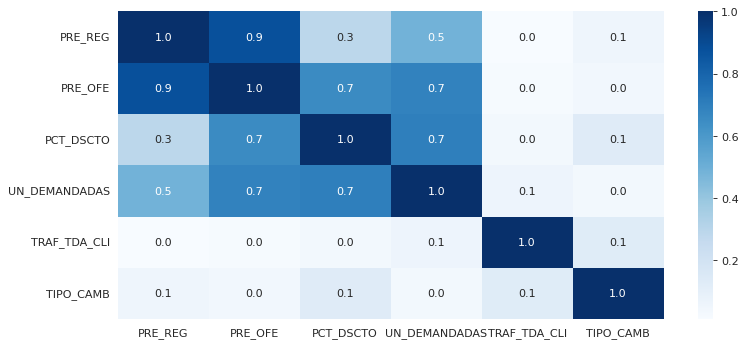

In [59]:
# Analizamos la correlacion de las variables
# Spearman: Para variables numericas. No asume normalidad
plt.figure(figsize=(11,5), dpi=80)
sns.heatmap(abs(df[columnsNumeric].corr(method='spearman')),annot=True,fmt='.1f',cmap='Blues')
plt.show()

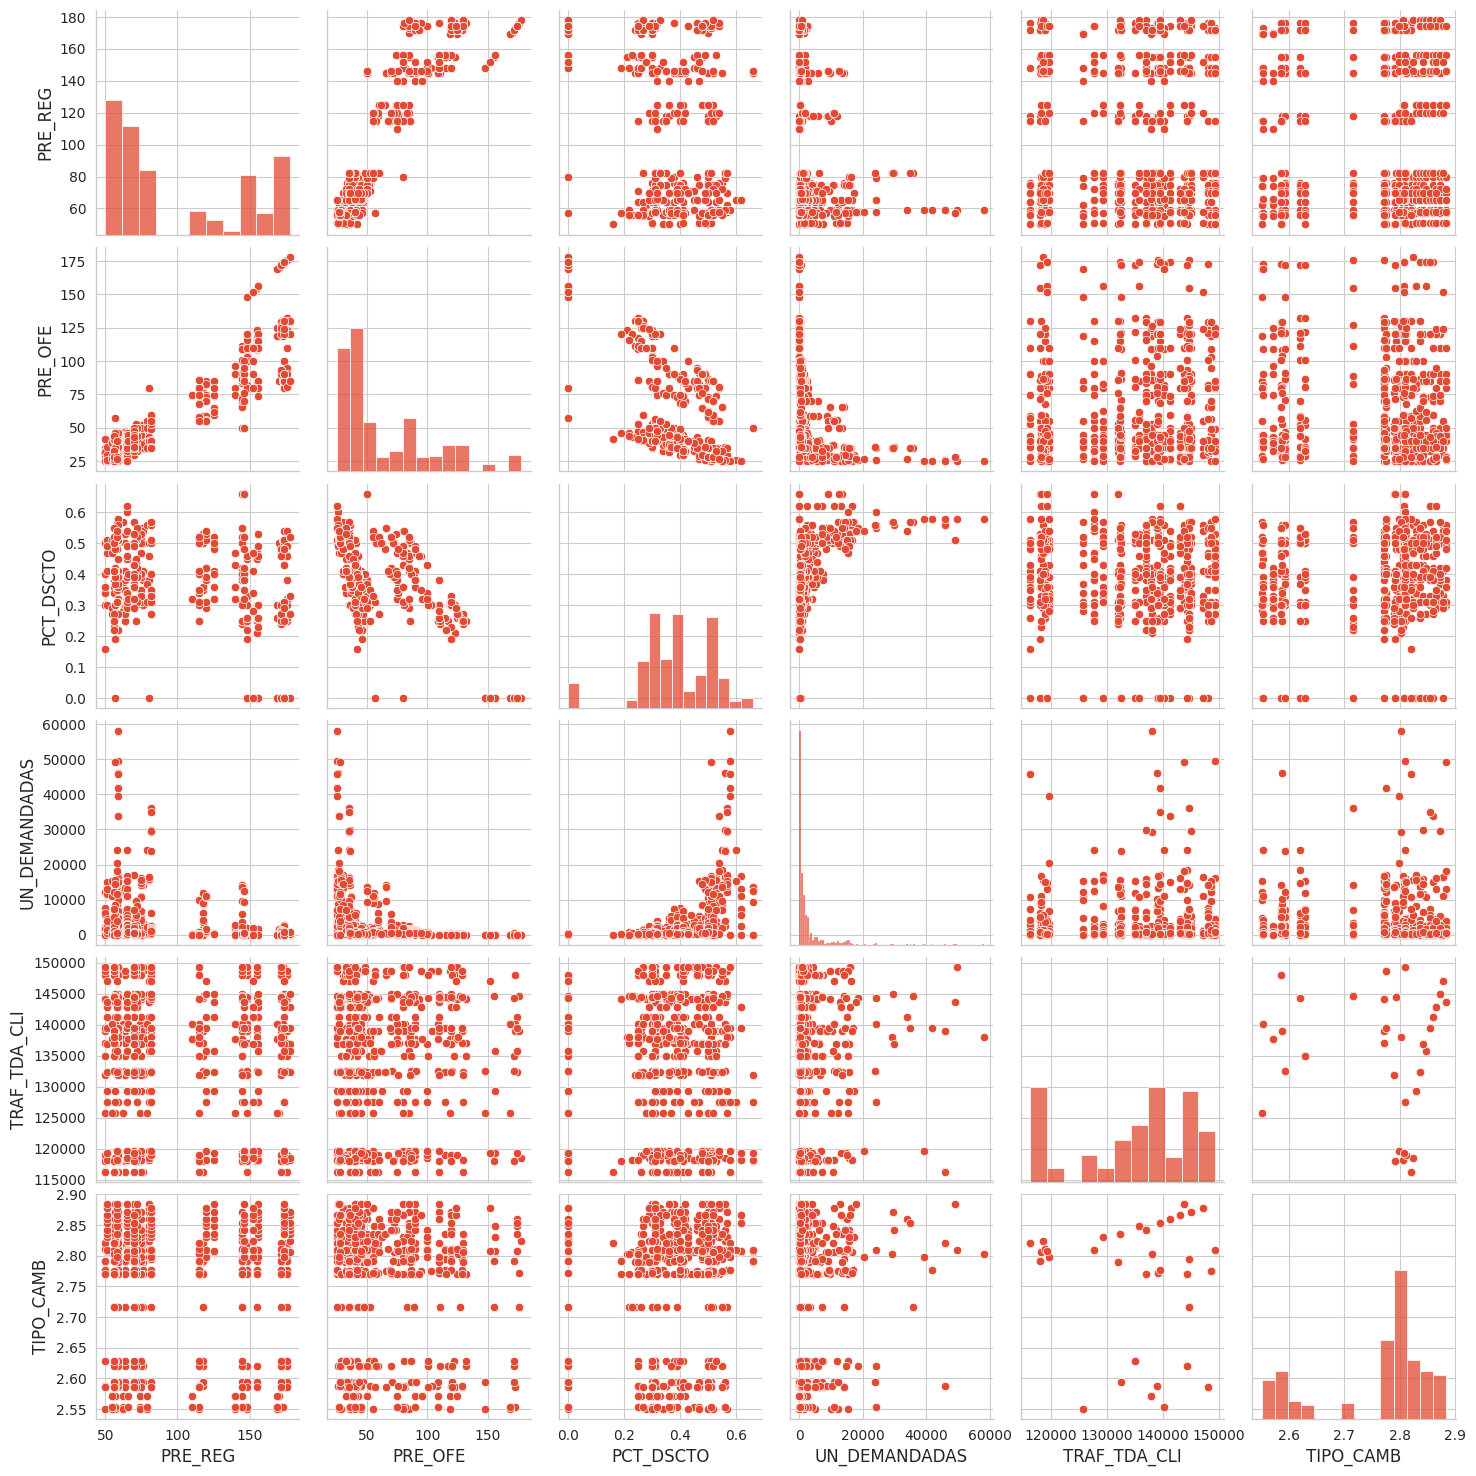

In [57]:
sns.pairplot(df[columnsNumeric])

## Linealidad

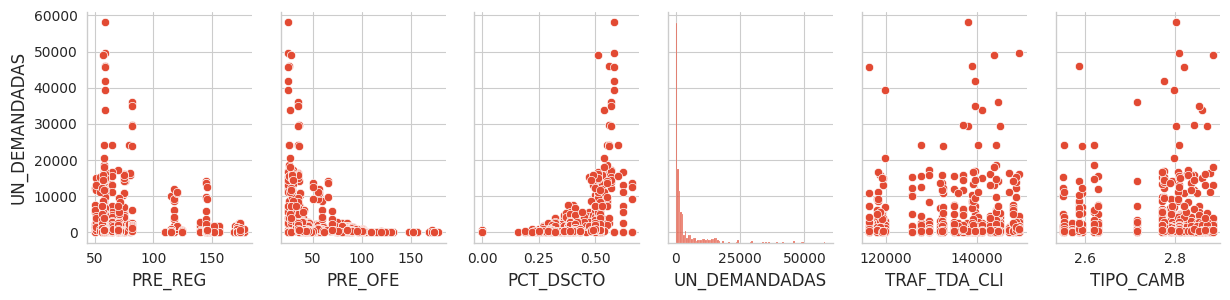

In [60]:
# Linealidad
p = sns.pairplot(df, x_vars = columnsNumeric,
                 y_vars='UN_DEMANDADAS', size=3, aspect=0.7)

### VIF

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [64]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[columnsNumeric].values, i) for i in range(df[columnsNumeric].shape[1])]
vif["features"] = df[columnsNumeric].columns
vif

,VIF Factor,features
0,156.466293,PRE_REG
1,165.996490,PRE_OFE
2,96.610168,PCT_DSCTO
3,1.912061,UN_DEMANDADAS
4,130.928714,TRAF_TDA_CLI
5,190.279638,TIPO_CAMB


## Asimetria

Calculamos el Coeficiente de Asimetría

In [65]:
from scipy import stats

In [66]:
data_ca = {'Variable' : columnsNumeric,
       'Coeficiente_Asim' : stats.skew(df[columnsNumeric])}
asim = pd.DataFrame(data_ca)
asim

,Variable,Coeficiente_Asim
0,PRE_REG,0.580543
1,PRE_OFE,1.190167
2,PCT_DSCTO,-0.822411
3,UN_DEMANDADAS,4.052209
4,TRAF_TDA_CLI,-0.534750
5,TIPO_CAMB,-0.976151


## Tratamiento de Nulos

In [67]:
df.isnull().sum().sort_values(ascending=False)

DESC_PROD        0
UBICA            0
PRE_REG          0
PRE_OFE          0
PCT_DSCTO        0
UN_DEMANDADAS    0
TRAF_TDA_CLI     0
TIPO_CAMB        0
dtype: int64

In [68]:
df.isnull().sum()/df.shape[0]*100

DESC_PROD        0.0
UBICA            0.0
PRE_REG          0.0
PRE_OFE          0.0
PCT_DSCTO        0.0
UN_DEMANDADAS    0.0
TRAF_TDA_CLI     0.0
TIPO_CAMB        0.0
dtype: float64

# **III. Recodificacion Data**

In [69]:
from sklearn.preprocessing import LabelEncoder

In [70]:
for i in columnsString:
    print(i)
    le = LabelEncoder()
    le.fit(df[str(i)])
    df[str(i)]=le.transform(df[str(i)])

UBICA
DESC_PROD


In [71]:
print(df.shape)
df.head(3)

(646, 8)


,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,UN_DEMANDADAS,TRAF_TDA_CLI,TIPO_CAMB
0,12,2,74,44.9,0.39,751,140209,2.554
1,12,2,74,49.9,0.33,736,137783,2.572
2,12,2,76,46.9,0.38,1130,132480,2.594


In [72]:
target = ['UN_DEMANDADAS']
inputs = [x for x in df.columns if x not in target]

In [73]:
inputs

['DESC_PROD',
 'UBICA',
 'PRE_REG',
 'PRE_OFE',
 'PCT_DSCTO',
 'TRAF_TDA_CLI',
 'TIPO_CAMB']

## Estandarizacion

In [74]:
from sklearn.preprocessing import RobustScaler

In [75]:
df_inputs = df[inputs]
df_inputs.head(3)

,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB
0,12,2,74,44.9,0.39,140209,2.554
1,12,2,74,49.9,0.33,137783,2.572
2,12,2,76,46.9,0.38,132480,2.594


In [76]:
transformer = RobustScaler().fit(df_inputs)

df_inputs_s = transformer.transform(df_inputs)
df_inputs_s = pd.DataFrame(df_inputs_s,columns=inputs)
df_inputs_s.head(3)

,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB
0,0.0,0.0,-0.011494,0.000000,0.000000,0.146383,-2.259259
1,0.0,0.0,-0.011494,0.098522,-0.315789,0.000000,-2.092593
2,0.0,0.0,0.011494,0.039409,-0.052632,-0.319978,-1.888889


In [77]:
df2 = df.reset_index(drop=True)
df2.head(3)

,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,UN_DEMANDADAS,TRAF_TDA_CLI,TIPO_CAMB
0,12,2,74,44.9,0.39,751,140209,2.554
1,12,2,74,49.9,0.33,736,137783,2.572
2,12,2,76,46.9,0.38,1130,132480,2.594


In [78]:
df_model = pd.concat([df_inputs_s,df2[target]],axis=1)
df_model.head(3)

,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB,UN_DEMANDADAS
0,0.0,0.0,-0.011494,0.000000,0.000000,0.146383,-2.259259,751
1,0.0,0.0,-0.011494,0.098522,-0.315789,0.000000,-2.092593,736
2,0.0,0.0,0.011494,0.039409,-0.052632,-0.319978,-1.888889,1130


# **IV. Modelado**

In [79]:
df.head()

,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,UN_DEMANDADAS,TRAF_TDA_CLI,TIPO_CAMB
0,12,2,74,44.9,0.39,751,140209,2.554
1,12,2,74,49.9,0.33,736,137783,2.572
2,12,2,76,46.9,0.38,1130,132480,2.594
3,12,2,76,52.9,0.30,512,144259,2.621
4,12,2,76,52.9,0.30,470,144582,2.716


In [80]:
df_model_2 = pd.concat([df_prev[['CODMES','CODPROD']],df_model],axis=1)
print(df_model_2.shape)
df_model_2.head(3)

(646, 10)


,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB,UN_DEMANDADAS
0,201802,8019010,0.0,0.0,-0.011494,0.000000,0.000000,0.146383,-2.259259,751
1,201803,8019010,0.0,0.0,-0.011494,0.098522,-0.315789,0.000000,-2.092593,736
2,201805,8019010,0.0,0.0,0.011494,0.039409,-0.052632,-0.319978,-1.888889,1130


<Axes: >

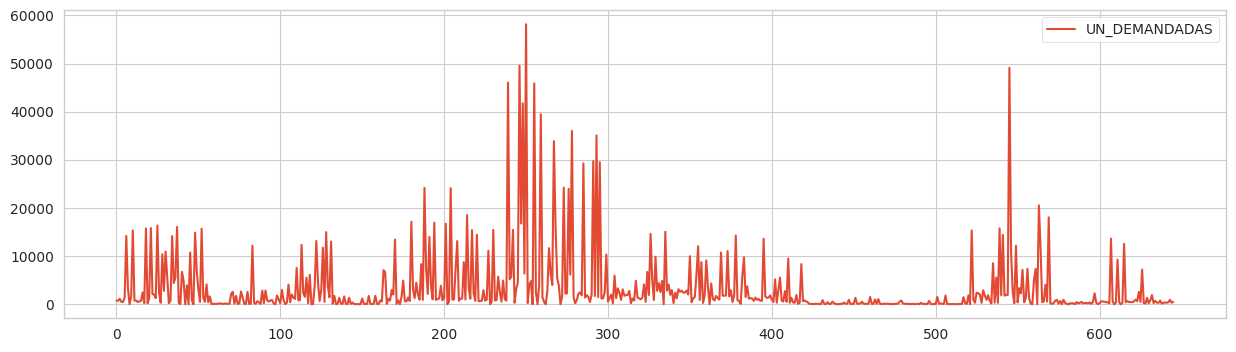

In [81]:
df_model_2.plot(y=['UN_DEMANDADAS'], figsize=(15,4))

In [82]:
datos_train = df_model_2.loc[df_model_2['CODMES']<202001]
datos_test = df_model_2.loc[df_model_2['CODMES']>=202001]

In [83]:
X_train = datos_train[inputs].values
y_train = datos_train[target].values

y_test = datos_test[target].values
X_test = datos_test[inputs].values

In [84]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (457, 7)
y_train shape (457, 1)
X_test shape (189, 7)
y_test shape (189, 1)


## Random Forest Regressor

In [85]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [86]:
rfreg_1 = RandomForestRegressor(n_estimators=500, max_features=5, random_state=1, n_jobs=-1)
rfreg_1.fit(X_train, y_train)

pd.DataFrame({'feature':inputs, 'importance':rfreg_1.feature_importances_}).sort_values('importance',ascending=False)

,feature,importance
4,PCT_DSCTO,0.425525
0,DESC_PROD,0.175751
3,PRE_OFE,0.120909
5,TRAF_TDA_CLI,0.094697
6,TIPO_CAMB,0.074138
1,UBICA,0.061987
2,PRE_REG,0.046994


In [87]:
y_pred_train =  rfreg_1.predict(X_train)
y_pred_test =  rfreg_1.predict(X_test)

In [88]:
datos_test = datos_test.reset_index(drop=True)
ypred = {'FORECAST_1': y_pred_test}
datos_test = pd.concat([datos_test,pd.DataFrame(ypred)], axis=1)
print(datos_test.shape)
datos_test.head(2)

(189, 11)


,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB,UN_DEMANDADAS,FORECAST_1
0,202001,8019010,0.0,-1.0,0.057471,-0.196059,0.894737,-0.613528,0.111111,2460,17967.557
1,202001,8019010,0.0,0.0,0.057471,0.197044,-0.421053,-0.613528,0.111111,243,718.640


In [89]:
datos_test['error_abs']=np.absolute(datos_test['FORECAST_1']-datos_test['UN_DEMANDADAS'])
datos_test['error_abs_d']=np.absolute((datos_test['FORECAST_1']-datos_test['UN_DEMANDADAS'])/datos_test['UN_DEMANDADAS'])
print(datos_test.shape)
datos_test.head(3)

(189, 13)


,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB,UN_DEMANDADAS,FORECAST_1,error_abs,error_abs_d
0,202001,8019010,0.0,-1.0,0.057471,-0.196059,0.894737,-0.613528,0.111111,2460,17967.557,15507.557,6.303885
1,202001,8019010,0.0,0.0,0.057471,0.197044,-0.421053,-0.613528,0.111111,243,718.640,475.640,1.957366
2,202002,8019010,0.0,-2.0,0.057471,-0.197044,0.894737,-1.160381,0.240741,15745,13797.788,1947.212,0.123672


In [90]:
col_det_1 = ['BIAS_m1','MAPE_m1']
resumen_prod_1 = pd.concat([pd.DataFrame(datos_test.groupby(['CODPROD']).error_abs.mean()),pd.DataFrame(datos_test.groupby(['CODPROD']).error_abs_d.mean())],axis=1)
resumen_prod_x = resumen_prod_1.values
resumen_prod_x = pd.DataFrame(resumen_prod_x, columns= col_det_1)
resumen_prod_x

,BIAS_m1,MAPE_m1
0,2734.953917,1.171940
1,798.558238,0.303658
2,859.822571,0.841411
3,476.619167,1.189872
4,4140.195668,2.167880
5,639.987600,8.485437
6,1006.303583,0.321614
7,5507.174333,2.254770
8,5952.156000,3.658972
9,8431.146909,NaN


In [91]:
resumen_prod_x.index = resumen_prod_1.index
resumen_prod_x

,BIAS_m1,MAPE_m1
CODPROD,,
8019010,2734.953917,1.171940
13019250,798.558238,0.303658
14019010,859.822571,0.841411
20019150,476.619167,1.189872
74019010,4140.195668,2.167880
76019110,639.987600,8.485437
78019010,1006.303583,0.321614
81019010,5507.174333,2.254770
91019010,5952.156000,3.658972


<Axes: >

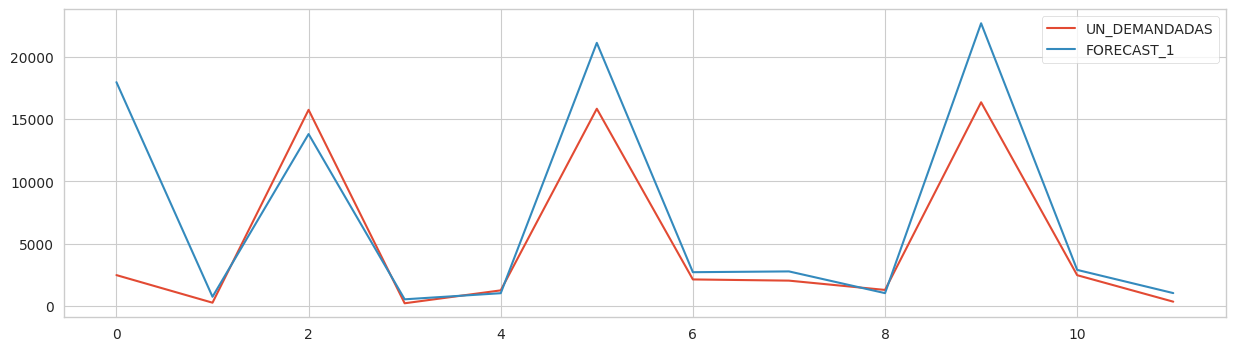

In [92]:
test_prod = datos_test[datos_test['CODPROD']==8019010]
test_prod.plot(y=['UN_DEMANDADAS','FORECAST_1'], figsize=(15,4))

## Heurística

In [93]:
data_model_3 = df_model_2.copy()

In [94]:
data_model_3['UN_DEMANDADAS_1'] = data_model_3['UN_DEMANDADAS'].shift(1)
data_model_3['UN_DEMANDADAS_2'] = data_model_3['UN_DEMANDADAS'].shift(2)
data_model_3['UN_DEMANDADAS_3'] = data_model_3['UN_DEMANDADAS'].shift(3)
data_model_3['UN_DEMANDADAS_4'] = data_model_3['UN_DEMANDADAS'].shift(4)
data_model_3['UN_DEMANDADAS_5'] = data_model_3['UN_DEMANDADAS'].shift(5)
data_model_3['UN_DEMANDADAS_6'] = data_model_3['UN_DEMANDADAS'].shift(6)

In [95]:
data_model_3.loc[data_model_3['CODPROD']==8019010].head(4)

,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB,UN_DEMANDADAS,UN_DEMANDADAS_1,UN_DEMANDADAS_2,UN_DEMANDADAS_3,UN_DEMANDADAS_4,UN_DEMANDADAS_5,UN_DEMANDADAS_6
0,201802,8019010,0.0,0.0,-0.011494,0.000000,0.000000,0.146383,-2.259259,751,NaN,NaN,NaN,NaN,NaN,NaN
1,201803,8019010,0.0,0.0,-0.011494,0.098522,-0.315789,0.000000,-2.092593,736,751.0,NaN,NaN,NaN,NaN,NaN
2,201805,8019010,0.0,0.0,0.011494,0.039409,-0.052632,-0.319978,-1.888889,1130,736.0,751.0,NaN,NaN,NaN,NaN
3,201807,8019010,0.0,0.0,0.011494,0.157635,-0.473684,0.390756,-1.638889,512,1130.0,736.0,751.0,NaN,NaN,NaN


In [96]:
data_model_3 = data_model_3.fillna(data_model_3.median())

In [97]:
data_model_3['AVG_DEM_U2M'] = (data_model_3['UN_DEMANDADAS_1'] + data_model_3['UN_DEMANDADAS_2'])/2
data_model_3['AVG_DEM_U3M'] = (data_model_3['UN_DEMANDADAS_1'] + data_model_3['UN_DEMANDADAS_2'] + data_model_3['UN_DEMANDADAS_3'])/3
data_model_3['AVG_DEM_U4M'] = (data_model_3['UN_DEMANDADAS_1'] + data_model_3['UN_DEMANDADAS_2'] + data_model_3['UN_DEMANDADAS_3'] + data_model_3['UN_DEMANDADAS_4'])/4
data_model_3['AVG_DEM_U5M'] = (data_model_3['UN_DEMANDADAS_1'] + data_model_3['UN_DEMANDADAS_2'] + data_model_3['UN_DEMANDADAS_3'] + data_model_3['UN_DEMANDADAS_4']+ data_model_3['UN_DEMANDADAS_5'])/5
data_model_3['AVG_DEM_U6M'] = (data_model_3['UN_DEMANDADAS_1'] + data_model_3['UN_DEMANDADAS_2'] + data_model_3['UN_DEMANDADAS_3'] + data_model_3['UN_DEMANDADAS_4']+ data_model_3['UN_DEMANDADAS_5'] + data_model_3['UN_DEMANDADAS_6'])/6

In [98]:
datos_train = data_model_3.loc[data_model_3['CODMES']<202001]
datos_test = data_model_3.loc[data_model_3['CODMES']>=202001]

In [99]:
dat_err = {'ERROR_H':np.absolute(datos_test['AVG_DEM_U6M']-datos_test['UN_DEMANDADAS'])}

datos_test = pd.concat([datos_test,pd.DataFrame(dat_err)], axis=1)
datos_test.head(3)

,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB,UN_DEMANDADAS,UN_DEMANDADAS_1,UN_DEMANDADAS_2,UN_DEMANDADAS_3,UN_DEMANDADAS_4,UN_DEMANDADAS_5,UN_DEMANDADAS_6,AVG_DEM_U2M,AVG_DEM_U3M,AVG_DEM_U4M,AVG_DEM_U5M,AVG_DEM_U6M,ERROR_H
16,202001,8019010,0.0,-1.0,0.057471,-0.196059,0.894737,-0.613528,0.111111,2460,689.0,619.0,461.0,790.0,737.0,15353.0,654.0,589.666667,639.75,659.2,3108.166667,648.166667
17,202001,8019010,0.0,0.0,0.057471,0.197044,-0.421053,-0.613528,0.111111,243,2460.0,689.0,619.0,461.0,790.0,737.0,1574.5,1256.000000,1057.25,1003.8,959.333333,716.333333
18,202002,8019010,0.0,-2.0,0.057471,-0.197044,0.894737,-1.160381,0.240741,15745,243.0,2460.0,689.0,619.0,461.0,790.0,1351.5,1130.666667,1002.75,894.4,877.000000,14868.000000


In [100]:
dat_err_2 = {'ERROR_H_D': np.absolute((datos_test['AVG_DEM_U6M']-datos_test['UN_DEMANDADAS'])/datos_test['UN_DEMANDADAS'])}

datos_test = pd.concat([datos_test,pd.DataFrame(dat_err_2)], axis=1)
datos_test.head(3)

,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB,UN_DEMANDADAS,UN_DEMANDADAS_1,UN_DEMANDADAS_2,UN_DEMANDADAS_3,UN_DEMANDADAS_4,UN_DEMANDADAS_5,UN_DEMANDADAS_6,AVG_DEM_U2M,AVG_DEM_U3M,AVG_DEM_U4M,AVG_DEM_U5M,AVG_DEM_U6M,ERROR_H,ERROR_H_D
16,202001,8019010,0.0,-1.0,0.057471,-0.196059,0.894737,-0.613528,0.111111,2460,689.0,619.0,461.0,790.0,737.0,15353.0,654.0,589.666667,639.75,659.2,3108.166667,648.166667,0.263482
17,202001,8019010,0.0,0.0,0.057471,0.197044,-0.421053,-0.613528,0.111111,243,2460.0,689.0,619.0,461.0,790.0,737.0,1574.5,1256.000000,1057.25,1003.8,959.333333,716.333333,2.947874
18,202002,8019010,0.0,-2.0,0.057471,-0.197044,0.894737,-1.160381,0.240741,15745,243.0,2460.0,689.0,619.0,461.0,790.0,1351.5,1130.666667,1002.75,894.4,877.000000,14868.000000,0.944300


In [101]:
col_det_2 = ['BIAS_m2','MAPE_m2']
resumen_prod_2 = pd.concat([pd.DataFrame(datos_test.groupby(['CODPROD']).ERROR_H.mean()),pd.DataFrame(datos_test.groupby(['CODPROD']).ERROR_H_D.mean())],axis=1)
resumen_prod_y = resumen_prod_2.values
resumen_prod_y = pd.DataFrame(resumen_prod_y, columns= col_det_2)
resumen_prod_y

,BIAS_m2,MAPE_m2
0,5790.083333,4.365160
1,5120.761905,5.656536
2,1087.023810,7.161180
3,1134.666667,5.917551
4,4625.888889,2.558240
5,575.550000,8.060842
6,3872.638889,0.997425
7,7921.500000,4.025902
8,4451.305556,2.971906
9,9135.242424,NaN


In [102]:
resumen_prod_y.index = resumen_prod_2.index
resumen_prod_y

,BIAS_m2,MAPE_m2
CODPROD,,
8019010,5790.083333,4.365160
13019250,5120.761905,5.656536
14019010,1087.023810,7.161180
20019150,1134.666667,5.917551
74019010,4625.888889,2.558240
76019110,575.550000,8.060842
78019010,3872.638889,0.997425
81019010,7921.500000,4.025902
91019010,4451.305556,2.971906


In [103]:
resumen_metodos = pd.concat([resumen_prod_x,resumen_prod_y],axis=1)
resumen_metodos

,BIAS_m1,MAPE_m1,BIAS_m2,MAPE_m2
CODPROD,,,,
8019010,2734.953917,1.171940,5790.083333,4.365160
13019250,798.558238,0.303658,5120.761905,5.656536
14019010,859.822571,0.841411,1087.023810,7.161180
20019150,476.619167,1.189872,1134.666667,5.917551
74019010,4140.195668,2.167880,4625.888889,2.558240
76019110,639.987600,8.485437,575.550000,8.060842
78019010,1006.303583,0.321614,3872.638889,0.997425
81019010,5507.174333,2.254770,7921.500000,4.025902
91019010,5952.156000,3.658972,4451.305556,2.971906


In [104]:
test_prod = datos_test[datos_test['CODPROD']==390019018]
test_prod

,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,TRAF_TDA_CLI,TIPO_CAMB,UN_DEMANDADAS,UN_DEMANDADAS_1,UN_DEMANDADAS_2,UN_DEMANDADAS_3,UN_DEMANDADAS_4,UN_DEMANDADAS_5,UN_DEMANDADAS_6,AVG_DEM_U2M,AVG_DEM_U3M,AVG_DEM_U4M,AVG_DEM_U5M,AVG_DEM_U6M,ERROR_H,ERROR_H_D
641,202003,390019018,-0.166667,0.0,-0.057471,-0.098522,0.210526,-0.508960,0.296296,338,373.0,308.0,137.0,747.0,307.0,339.0,340.5,272.666667,391.25,374.4,368.500000,30.500000,0.090237
642,202004,390019018,-0.166667,0.0,-0.057471,0.000000,-0.157895,-0.327762,0.351852,423,338.0,373.0,308.0,137.0,747.0,307.0,355.5,339.666667,289.00,380.6,368.333333,54.666667,0.129236
643,202005,390019018,-0.166667,-1.0,-0.057471,-0.197044,0.578947,-0.055391,0.407407,922,423.0,338.0,373.0,308.0,137.0,747.0,380.5,378.000000,360.50,315.8,387.666667,534.333333,0.579537
644,202007,390019018,-0.166667,0.0,-0.057471,-0.039409,0.000000,0.103663,0.518519,339,922.0,423.0,338.0,373.0,308.0,137.0,672.5,561.000000,514.00,472.8,416.833333,77.833333,0.229597
645,202009,390019018,-0.166667,-1.0,-0.057471,-0.177340,0.526316,0.311712,0.629630,490,339.0,922.0,423.0,338.0,373.0,308.0,630.5,561.333333,505.50,479.0,450.500000,39.500000,0.080612


<Axes: >

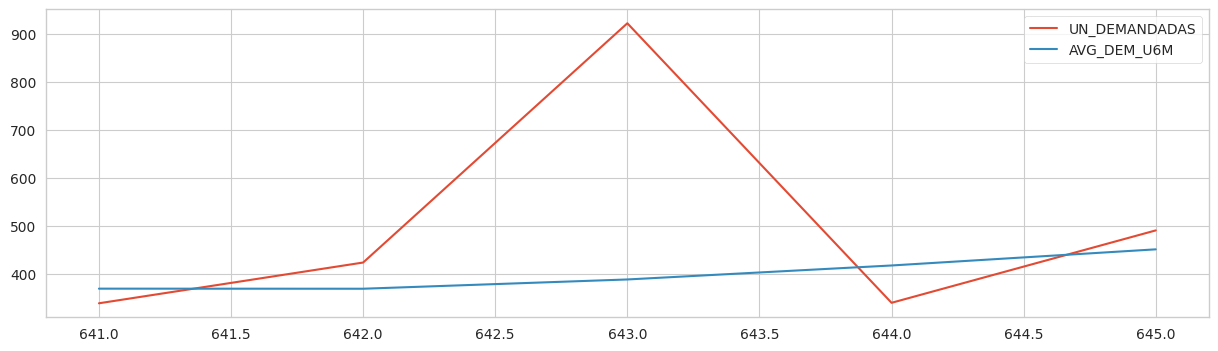

In [105]:
test_prod.plot(y=['UN_DEMANDADAS','AVG_DEM_U6M'], figsize=(15,4))

## Naive

In [106]:
datos_test = df_prev.loc[df_prev['CODMES']>=202001]
datos_test.head(3)

,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,UN_ESTIMADAS,UN_DEMANDADAS,TRAF_TDA_CLI,TIPO_CAMB,MAPE
16,202001,8019010,VELA PERFUMADA 3 MEDIANA,Centro de Anaquel,80,34.95,0.56,689,2460,127615,2.810,0.720
17,202001,8019010,VELA PERFUMADA 3 MEDIANA,Nivel Alto Anaquel,80,54.90,0.31,2460,243,127615,2.810,9.123
18,202002,8019010,VELA PERFUMADA 3 MEDIANA,Cabecera de Gondola,80,34.90,0.56,243,15745,118552,2.824,0.985


In [107]:
datos_test['error_abs']=np.absolute(datos_test['UN_ESTIMADAS']-datos_test['UN_DEMANDADAS'])
datos_test['error_abs_d']=np.absolute((datos_test['UN_ESTIMADAS']-datos_test['UN_DEMANDADAS'])/datos_test['UN_DEMANDADAS'])
datos_test.head(3)

,CODMES,CODPROD,DESC_PROD,UBICA,PRE_REG,PRE_OFE,PCT_DSCTO,UN_ESTIMADAS,UN_DEMANDADAS,TRAF_TDA_CLI,TIPO_CAMB,MAPE,error_abs,error_abs_d
16,202001,8019010,VELA PERFUMADA 3 MEDIANA,Centro de Anaquel,80,34.95,0.56,689,2460,127615,2.810,0.720,1771,0.719919
17,202001,8019010,VELA PERFUMADA 3 MEDIANA,Nivel Alto Anaquel,80,54.90,0.31,2460,243,127615,2.810,9.123,2217,9.123457
18,202002,8019010,VELA PERFUMADA 3 MEDIANA,Cabecera de Gondola,80,34.90,0.56,243,15745,118552,2.824,0.985,15502,0.984567


In [108]:
col_det_3 = ['BIAS_m3','MAPE_m3']
resumen_prod_3 = pd.concat([pd.DataFrame(datos_test.groupby(['CODPROD']).error_abs.mean()),pd.DataFrame(datos_test.groupby(['CODPROD']).error_abs_d.mean())],axis=1)
resumen_prod_z = resumen_prod_3.values
resumen_prod_z = pd.DataFrame(resumen_prod_z, columns= col_det_3)
resumen_prod_z

,BIAS_m3,MAPE_m3
0,8029.333333,9.349365
1,6317.857143,4.233595
2,1456.000000,7.522250
3,2045.666667,6.121248
4,8273.888889,4.256761
5,790.300000,6.682438
6,6444.500000,1.646653
7,11873.666667,7.138906
8,6627.166667,4.262176
9,10784.636364,NaN


In [109]:
resumen_prod_z.index = resumen_prod_3.index
resumen_prod_z

,BIAS_m3,MAPE_m3
CODPROD,,
8019010,8029.333333,9.349365
13019250,6317.857143,4.233595
14019010,1456.000000,7.522250
20019150,2045.666667,6.121248
74019010,8273.888889,4.256761
76019110,790.300000,6.682438
78019010,6444.500000,1.646653
81019010,11873.666667,7.138906
91019010,6627.166667,4.262176


In [110]:
resumen_metodos = pd.concat([resumen_metodos,resumen_prod_z],axis=1)
resumen_metodos

,BIAS_m1,MAPE_m1,BIAS_m2,MAPE_m2,BIAS_m3,MAPE_m3
CODPROD,,,,,,
8019010,2734.953917,1.171940,5790.083333,4.365160,8029.333333,9.349365
13019250,798.558238,0.303658,5120.761905,5.656536,6317.857143,4.233595
14019010,859.822571,0.841411,1087.023810,7.161180,1456.000000,7.522250
20019150,476.619167,1.189872,1134.666667,5.917551,2045.666667,6.121248
74019010,4140.195668,2.167880,4625.888889,2.558240,8273.888889,4.256761
76019110,639.987600,8.485437,575.550000,8.060842,790.300000,6.682438
78019010,1006.303583,0.321614,3872.638889,0.997425,6444.500000,1.646653
81019010,5507.174333,2.254770,7921.500000,4.025902,11873.666667,7.138906
91019010,5952.156000,3.658972,4451.305556,2.971906,6627.166667,4.262176


In [111]:
resumen_metodos.iloc[9,:]

BIAS_m1     8431.146909
MAPE_m1             NaN
BIAS_m2     9135.242424
MAPE_m2             NaN
BIAS_m3    10784.636364
MAPE_m3             NaN
Name: 102019010, dtype: float64

In [112]:
resumen_metodos.iloc[9,1] = 1
resumen_metodos.iloc[9,3] = 1
resumen_metodos.iloc[9,5] = 1

In [113]:
resumen_metodos.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BIAS_m1,25.0,2017.859075,2281.712998,32.833000,507.272667,859.822571,2734.953917,8431.146909
MAPE_m1,25.0,1.445203,1.688714,0.152597,0.530790,0.928804,2.000374,8.485437
BIAS_m2,25.0,3487.162301,3452.313805,102.555556,658.333333,2621.595238,5120.761905,12828.870370
MAPE_m2,25.0,3.292306,2.309363,0.221844,1.000000,2.971906,4.736860,8.060842
BIAS_m3,25.0,4820.919978,5010.988278,134.500000,1036.000000,3558.571429,7444.166667,20220.777778
MAPE_m3,25.0,4.284447,3.558510,0.564199,1.395918,4.233595,6.121248,15.717377
